# **Python最优化算法**

使用Python的SLSQP算法计算相同目标方程的最优解

In [18]:
import pandas as pd
import numpy as np
import DE as de
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## <font color = 'midnightblue'> **数据选取** </font>

在用实际数据测试阶段，主要是选取股票风格指数和大类资产例如债券和大宗商品，并构建三个投资组合分开进行配置策略研究。在第一个组合中，我们首先选用了市场上从2010/06/01至2020/09/30的11个ETF时间序列数据，分别为：*金融地产，上中游，下游，消费，成长，大盘成长，大盘价值，中盘成长，中盘价值，小盘成长，小盘价值*。 在第二个投资组合中，选取前文的股票风格ETF和剩余的大类资产指数：*中证全债，有色金属，易盛能化A，黄金*。在第三个组合中，只选取大类资产指数：*债券、有色金属、能源化工和黄金合约*，并将资金在其中分配寻找最优解。

### 资产组合1数据导入

In [98]:
col_names1 = ['万得全A','金融地产','上中游','下游','消费','成长','大盘成长','大盘价值','中盘成长','中盘价值','小盘成长','小盘价值']
prices_p1 = pd.read_csv(U"C:/Users/YUAN PUEN/Desktop/金融工程/JupyterLab/Data/stocks.csv",header = 0,names = col_names1, index_col=0,parse_dates=True)
prices_p1.columns = prices_p1.columns.str.strip()
prices_p1 = prices_p1.dropna()
prices_p1 = prices_p1.iloc[:,1:]
#由过去资产组合一的价格数据计算各类指数的收益
rets_p1 = prices_p1.pct_change().dropna()
rets_p1.head(2)

,金融地产,上中游,下游,消费,成长,大盘成长,大盘价值,中盘成长,中盘价值,小盘成长,小盘价值
2010-06-01,-0.010273,-0.004053,-0.014989,-0.013272,-0.027000,-0.012031,-0.010474,-0.017306,-0.021196,-0.019789,-0.020838
2010-06-02,0.001912,0.001480,0.014783,0.003363,0.024666,0.007880,-0.001950,0.011741,0.014436,0.012651,0.011742


### 资产组合2数据导入

In [99]:
col_names2 = ['万得全A','金融地产','上中游','下游','消费','成长','大盘成长','大盘价值','中盘成长','中盘价值','小盘成长','小盘价值','中证全债','有色金属','易盛能化A','黄金']
prices_p2 = pd.read_csv(U"C:/Users/YUAN PUEN/Desktop/金融工程/JupyterLab/Data/indices.csv",names = col_names2, header = 0,index_col=0,parse_dates=True)
prices_p2.columns = prices_p2.columns.str.strip()
prices_p2 = prices_p2.dropna()
prices_p2 = prices_p2.iloc[:,1:]
#根据资产组合的价格计算资产的收益
rets_p2 = prices_p2.pct_change().dropna()
rets_p2.head(2)

,金融地产,上中游,下游,消费,成长,大盘成长,大盘价值,中盘成长,中盘价值,小盘成长,小盘价值,中证全债,有色金属,易盛能化A,黄金
2012-01-05,0.003951,-0.018684,-0.029457,-0.026306,-0.056577,-0.005831,0.005525,-0.035588,-0.025219,-0.038685,-0.031547,-0.000358,0.004758,0.016301,0.009917
2012-01-06,0.006560,0.013414,0.001133,0.003212,0.002999,0.004608,0.005800,0.004750,0.008624,0.003917,0.005693,0.001649,-0.003222,0.004652,0.001807


### 资产组合3数据导入

In [100]:
col_names2 = ['万得全A','金融地产','上中游','下游','消费','成长','大盘成长','大盘价值','中盘成长','中盘价值','小盘成长','小盘价值','中证全债','有色金属','易盛能化A','黄金']
prices_p3 = pd.read_csv(U"C:/Users/YUAN PUEN/Desktop/金融工程/JupyterLab/Data/indices.csv",names = col_names2,header = 0,index_col=0,parse_dates=True)
prices_p3.columns = prices_p3.columns.str.strip()
prices_p3 = prices_p3.dropna()
prices_p3 = prices_p3.iloc[:,12:]
rets_p3 = prices_p3.pct_change().dropna()
rets_p3.head(4)

,中证全债,有色金属,易盛能化A,黄金
2012-01-05,-0.000358,0.004758,0.016301,0.009917
2012-01-06,0.001649,-0.003222,0.004652,0.001807
2012-01-09,0.001217,-0.006266,0.004865,-0.004630
2012-01-10,0.000858,0.007232,-0.004842,0.003051


## 构建目标方程最优化算法程序

- 最大夏普比方程

In [102]:
def annu_rets(r,T):
    """
    convert the non-annual returns to annualized returns
    r: non-annual returns series
    T: periods per year for the returns, i.e. T = 12 for onverting monthly data to annual
    """
    compounded_growth = (1+r).prod()
    t = r.shape[0] #number of periods, i.e. t=24 for 2-year monthly record
    return compounded_growth**(T/t)-1

def portfolio_return(weights,returns):
    """
    weights -> returns
    """
    return weights.T @ returns

def portfolio_vol(weights,covmatrix):
    """
    weights -> vol
    """
    return np.sqrt((weights.T @ covmatrix @ weights))*(252)**0.5

def obj_msr(rets):
    """
    Riskfree_rate + returns-> Weights Vector
    """
    riskfree_rate = 0.01
    #covmatrix of returns 
    cov = rets.cov()
    #annulize the returns
    annu_r  = annu_rets(rets,252)
    
    #find the number of assets
    n = annu_r.shape[0]
    init_guess = np.repeat(1/n,n)
    bounds = ((0.0, 1.0),)*n 
    weights_sum_to_1 = {
        'type':'eq',
        'fun': lambda weights: np.sum(weights)-1   
    }
    def neg_sharp_ratio(weights,riskfree_rate,annu_r,cov):
        """
        Returns the nagative of the sharp ratio, given weights
        minimize the negative sharp ratio means maximize the sharp ratio 
        """
        r = portfolio_return(weights,annu_r)
        vol = portfolio_vol(weights,cov)
        return -(r-riskfree_rate)/vol
        
    results = minimize(neg_sharp_ratio,init_guess,
                       args=(riskfree_rate, annu_r, cov,), method="SLSQP",
                       options={'disp':False},
                       constraints=(weights_sum_to_1),
                       bounds=bounds)
    return results.x

- 最小化最大回撤方程

In [103]:
def compute_drawdown(x):
    """
    calculate the drawdown for a given return series x 
    """
    cumulative_rets = (1+x).cumprod()
    max_cum_rets = cumulative_rets.cummax()
    drawdowns = - (cumulative_rets/max_cum_rets - 1)
    return drawdowns

def obj_mdd(rets):
    """
    objective function for minimizing the max dd
    """
    n = len(rets.columns)
    init_guess = np.repeat(1/n,n)
    bounds = ((0.0, 1.0),)*n 
    weights_sum_to_1 = {
        'type':'eq',
        'fun': lambda weights: np.sum(weights)-1   
    }
    
    def maxdd_to_minimize(weights,rets):
        """
        Returns the maximum sharp ratio, given weights
        """
        port_rets = rets @ weights 
        dd = compute_drawdown(port_rets)
        max_dd = dd.max()
        return max_dd
    results = minimize(maxdd_to_minimize,init_guess,
                       args=(rets,), method="SLSQP",
                       options={'disp':False},
                       constraints=(weights_sum_to_1),
                       bounds=bounds)
    return results.x

- 最小化预期损失方程

In [104]:
def obj_cvar(rets, level = 5):
    """
    objective function for minimizing CVaR
    """
    #covmatrix of returns 
    cov = rets.cov()
    #annulize the covariance matrix
    V = cov * 252
    #annulize the returns
    mu  = (1+rets.mean())**252 -1 
    
    #find the number of assets
    n = mu.shape[0]
    init_guess = np.repeat(1/n,n)
    bounds = ((0.0, 1.0),)*n 
    weights_sum_to_1 = {
        'type':'eq',
        'fun': lambda weights: np.sum(weights)-1   
    }
    def cvar(weights, rets, level = 5):
        
        alpha = level/100
        z = norm.ppf(alpha)
        covmatrix = cov
        annu_cov = V
        port_vol = ((weights @ covmatrix @ weights)**0.5) * np.sqrt(252)
    
        #compute the function
        cvar =  -(weights @ mu) + port_vol * z / alpha
        return -cvar
    
    results = minimize(cvar,init_guess,
                       args=(rets,), method="SLSQP",
                       options={'disp':False},
                       constraints=(weights_sum_to_1),
                       bounds=bounds)
    return results.x

- 风险平价方程

In [105]:
def risk_contribution(w,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio, given a set of portfolio weights and a covariance matrix
    """

    # Portfolio risk
    total_portfolio_var = w.T @ cov @ w
    # Marginal contribution of each constituent
    marginal_contrib = cov @ w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib


def target_risk_contributions(target_risk, cov):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)

- 预期损失均衡方程

In [106]:
def obj_cvar_equal(rets, level = 5):
    """
    objective function for equalize CVaR contribution
    """
    #covmatrix of returns 
    cov = rets.cov()
    #annulize the covariance matrix
    V = cov * 252
    #annulize the returns
    mu  = (1+rets.mean())**252 -1 
    
    #find the number of assets
    n = mu.shape[0]
    init_guess = np.repeat(1/n,n)
    bounds = ((0.0, 1.0),)*n 
    weights_sum_to_1 = {
        'type':'eq',
        'fun': lambda weights: np.sum(weights)-1   
    }
    def cvar_budgeting(weights, eq_risk, level = 5):
        
        alpha = level/100
        z = norm.ppf(alpha)
        covmatrix = cov
        annu_cov = V
        eq_risk = 1/n
        port_vol = ((weights @ covmatrix @ weights)**0.5) * np.sqrt(252)
        CW = annu_cov @ weights
        
        # compute the function
        cvar = -(weights @ mu) + port_vol * z / alpha
        # compute the cvar budgeting
        numerator = []
        for i in range(n):
            numerator.append(weights[i] * (-mu[i] + (CW[i] * z) / (port_vol * alpha)))
        ccvar = np.sum((numerator/cvar - eq_risk)**2)
        return ccvar
       
    results = minimize(cvar_budgeting,init_guess,
                       args=(rets,), method="SLSQP",
                       options={'disp':False},
                       constraints=(weights_sum_to_1),
                       bounds=bounds)
    return results.x

---

<font color = 'red'> **对资产组合 1 进行配置**

1. 最大化夏普比组合 

In [107]:
w_msr1 = obj_msr(rets_p1)
optim_msr1 = w_msr1 / sum(w_msr1)
optim_msr1

array([0.00000000e+00, 0.00000000e+00, 4.97252768e-17, 1.00000000e+00,
       4.99000113e-16, 1.10125645e-16, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.81795945e-17, 0.00000000e+00])

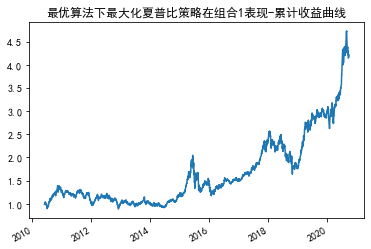

In [108]:
port_msr1 = np.sum(optim_msr1 * rets_p1,axis = 1)
cumrets_msr1 = (1+port_msr1).cumprod()
cumrets_msr1.plot(title = "最优算法下最大化夏普比策略在组合1表现-累计收益曲线")

In [109]:
de.Summary_Stats(pd.DataFrame(port_msr1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.153706,0.252166,-0.405622,5.987837,0.026356,0.037532,0.476328,-0.426665


2. 最小化最大回撤策略

In [110]:
optim_w_mdd1 = obj_mdd(rets_p1)/sum(obj_mdd(rets_p1))
optim_w_mdd1

array([1.95926427e-17, 5.16651178e-18, 3.12358903e-17, 2.57216339e-01,
       4.90427599e-18, 3.59632385e-01, 3.83151277e-01, 4.65334277e-17,
       4.36088594e-20, 3.61452344e-17, 3.05226950e-17])

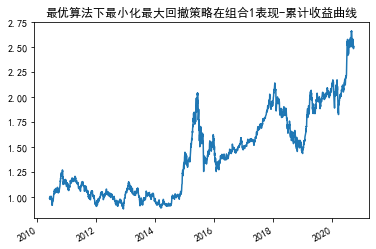

In [111]:
port_mdd1 = np.sum(optim_w_mdd1 * rets_p1,axis = 1)
cumrets_maxdd1 = (1+port_mdd1).cumprod()
cumrets_maxdd1.plot(title = "最优算法下最小化最大回撤策略在组合1表现-累计收益曲线")

In [112]:
de.Summary_Stats(pd.DataFrame(port_mdd1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.095591,0.221325,-0.473207,7.23057,0.023185,0.033634,0.287745,-0.385364


3. 最小化预期损失策略

In [113]:
optim_w_mincvar1 = obj_cvar(rets = rets_p1,level = 5)/sum(obj_cvar(rets_p1,5))
optim_w_mincvar1

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.18232991e-01,
       7.19734706e-02, 0.00000000e+00, 6.46494983e-01, 7.71667664e-17,
       0.00000000e+00, 6.32985561e-02, 1.63648875e-17])

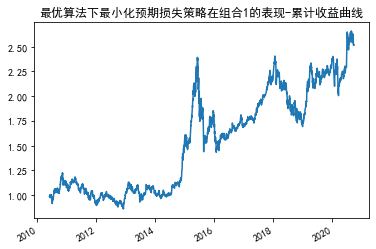

In [114]:
port_cvar1 = np.sum(optim_w_mincvar1 * rets_p1,axis = 1)
cumrets_cvar1 = (1+port_cvar1).cumprod()
cumrets_cvar1.plot(title = "最优算法下最小化预期损失策略在组合1的表现-累计收益曲线")

In [115]:
de.Summary_Stats(pd.DataFrame(port_cvar1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.096107,0.213982,-0.511669,7.615141,0.022438,0.032686,0.299964,-0.401097


4. 风险平价组合

In [116]:
cov1 = rets_p1.cov()*250
optim_w_rp1 = equal_risk_contributions(cov1)
optim_w_rp1

array([0.102642  , 0.0864254 , 0.08196465, 0.09970852, 0.08194458,
       0.09521594, 0.11447428, 0.08551649, 0.08528155, 0.08382648,
       0.08300012])

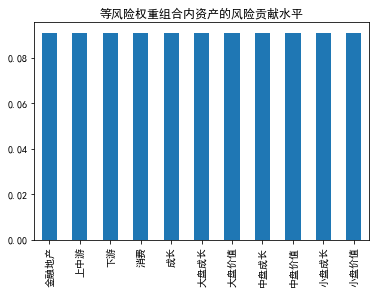

In [117]:
risk_contribution(optim_w_rp1, cov1).plot.bar(title="等风险权重组合内资产的风险贡献水平");

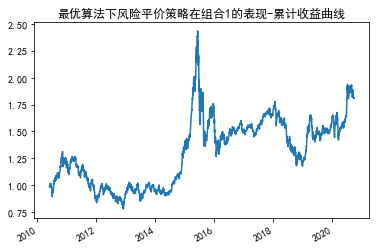

In [118]:
port_RP1 = np.sum(optim_w_rp1* rets_p1,axis = 1)
cumrets_RP1 = (1+port_RP1).cumprod()
cumrets_RP1.plot(title = "最优算法下风险平价策略在组合1的表现-累计收益曲线")

In [119]:
de.Summary_Stats(pd.DataFrame(port_RP1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.060801,0.234945,-0.677288,7.078565,0.025599,0.037626,0.127281,-0.516818


5. 等预期损失贡献组合

In [36]:
optim_w_ccvar1 = obj_cvar_equal(rets_p1,5)
optim_w_ccvar1

array([0.10260049, 0.08753916, 0.08218749, 0.09828653, 0.08148096,
       0.09512221, 0.11402307, 0.08579373, 0.08559105, 0.08410417,
       0.08327113])

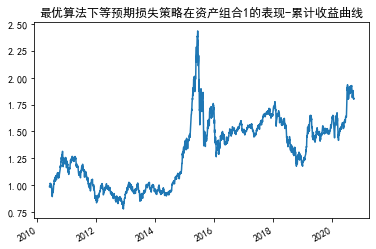

In [45]:
port_ccvar1 = np.sum(optim_w_ccvar1 * rets_p1,axis = 1)
cumrets_ccvar1 = (1+port_ccvar1).cumprod()
cumrets_ccvar1.plot(title = "最优算法下等预期损失策略在资产组合1的表现-累计收益曲线")

In [38]:
de.Summary_Stats(pd.DataFrame(port_ccvar1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.060476,0.235027,-0.677599,7.07932,0.02561,0.037644,0.125892,-0.517492


6. 等权重组合

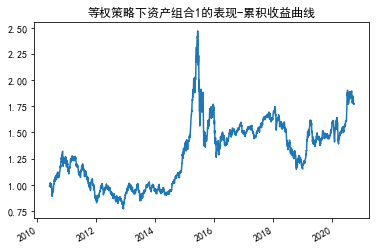

In [39]:
weights_eq1 = [1/11]*11
eqport_rets1= np.sum(weights_eq1 * rets_p1,axis = 1)
cumrets_eq1 = (1+eqport_rets1).cumprod()
cumrets_eq1.plot(title="等权策略下资产组合1的表现-累积收益曲线")

In [40]:
de.Summary_Stats(pd.DataFrame(eqport_rets1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.058559,0.237758,-0.686997,7.011464,0.025973,0.038228,0.116621,-0.534938


## 生成图例

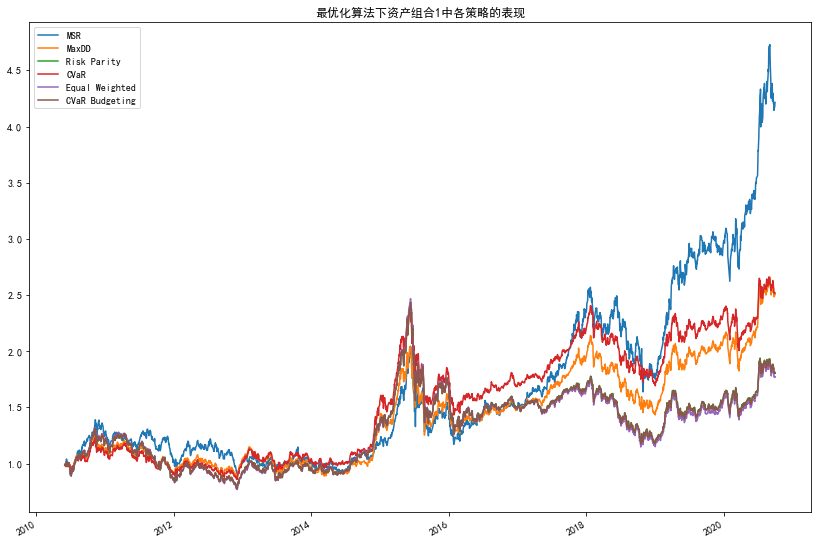

In [41]:
cumrets_msr1.plot(figsize=(14,10),label = "MSR",title = "最优化算法下资产组合1中各策略的表现" , legend = True)
cumrets_maxdd1.plot(figsize=(14,10),label = "MaxDD", legend = True)
cumrets_RP1.plot(figsize=(14,10),label = "Risk Parity", legend = True)
cumrets_cvar1.plot(figsize=(14,10),label = "CVaR" , legend = True)
cumrets_eq1.plot(figsize=(14,10),label = "Equal Weighted", legend = True)
cumrets_ccvar1.plot(figsize=(14,10),label = "CVaR Budgeting", legend = True)

In [42]:
btr_scipy1 = pd.DataFrame({"SR Portfolio": port_msr1, "MaxDD Portfolio": port_mdd1, "RP Portfolio": port_RP1, "CVaR Portfolio": port_cvar1, "CVaR Budgeting": port_ccvar1,"EQ Portfolio": eqport_rets1})
de.Summary_Stats(btr_scipy1)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
SR Portfolio,0.153706,0.252166,-0.405622,5.987837,0.026356,0.037532,0.476328,-0.426665
MaxDD Portfolio,0.095591,0.221325,-0.473207,7.230570,0.023185,0.033634,0.287745,-0.385364
RP Portfolio,0.060801,0.234945,-0.677288,7.078565,0.025599,0.037626,0.127281,-0.516818
CVaR Portfolio,0.096107,0.213982,-0.511669,7.615141,0.022438,0.032686,0.299964,-0.401097
CVaR Budgeting,0.060476,0.235027,-0.677599,7.079320,0.025610,0.037644,0.125892,-0.517492
EQ Portfolio,0.058559,0.237758,-0.686997,7.011464,0.025973,0.038228,0.116621,-0.534938


<font color = 'red'> **对第二个组合进行配置**

1. 最大化夏普比组合 

In [43]:
w_msr2 = obj_msr(rets_p2)
optim_msr2 = w_msr2 / sum(w_msr2)
optim_msr2

array([1.13471691e-13, 1.21109125e-12, 7.74575462e-13, 1.59760674e-02,
       1.07814655e-11, 1.00473460e-12, 1.43399752e-12, 7.67600533e-13,
       6.64717905e-13, 7.22568898e-13, 7.05596123e-13, 9.84023933e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

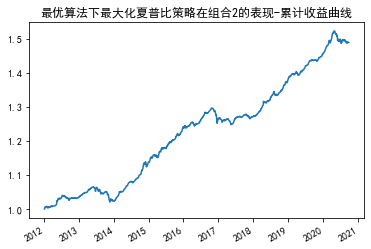

In [44]:
port_msr2 = np.sum(optim_msr2 * rets_p2,axis = 1)
cumrets_msr2 = (1+port_msr2).cumprod()
cumrets_msr2.plot(title = "最优算法下最大化夏普比策略在组合2的表现-累计收益曲线")

In [50]:
de.Summary_Stats(pd.DataFrame(port_msr2))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.047908,0.013422,-0.200703,12.049224,0.001101,0.001829,1.295525,-0.042126


2. 最小化最大回撤策略

In [51]:
optim_w_mdd2 = obj_mdd(rets_p2)/sum(obj_mdd(rets_p2))
optim_w_mdd2

array([6.24544263e-17, 1.79825931e-19, 1.23799626e-19, 5.10257363e-02,
       6.76462248e-03, 4.58793230e-17, 1.56291672e-17, 1.71884524e-18,
       1.20620093e-19, 1.15746882e-20, 9.80426548e-18, 8.08433216e-01,
       4.07501539e-02, 8.77564465e-02, 5.26982521e-03])

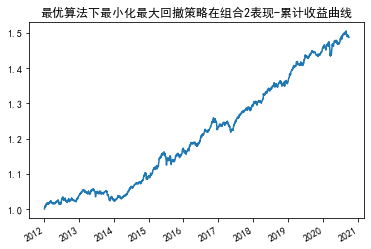

In [52]:
port_mdd2 = np.sum(optim_w_mdd2 * rets_p2,axis = 1)
cumrets_maxdd2 = (1+port_mdd2).cumprod()
cumrets_maxdd2.plot(title = "最优算法下最小化最大回撤策略在组合2表现-累计收益曲线")

In [53]:
de.Summary_Stats(pd.DataFrame(port_mdd2))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.047815,0.02727,-0.072649,4.770027,0.002622,0.00373,0.634326,-0.032588


3. 最小化预期损失策略

In [54]:
optim_w_mincvar2 = obj_cvar(rets = rets_p2,level = 5)/sum(obj_cvar(rets_p2,5))
optim_w_mincvar2

array([1.46888677e-03, 7.14939172e-16, 1.31902457e-03, 3.94071235e-04,
       1.11222003e-16, 1.39056458e-17, 7.83258657e-18, 5.80526599e-18,
       4.01968275e-18, 7.17015804e-17, 6.13297580e-17, 9.79798096e-01,
       9.63973853e-03, 7.07303850e-03, 3.07144406e-04])

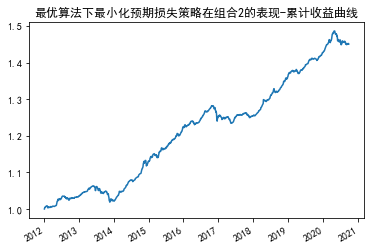

In [55]:
port_cvar2 = np.sum(optim_w_mincvar2 * rets_p2,axis = 1)
cumrets_cvar2 = (1+port_cvar2).cumprod()
cumrets_cvar2.plot(title = "最优算法下最小化预期损失策略在组合2的表现-累计收益曲线")

In [57]:
de.Summary_Stats(pd.DataFrame(port_cvar2))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.044721,0.013008,-0.190178,12.971645,0.001056,0.001802,1.098805,-0.0421


4. 风险平价组合

In [120]:
cov2 = rets_p2.corr()
optim_w_rp2 = equal_risk_contributions(cov2)
optim_w_rp2

array([0.05265383, 0.04659353, 0.04694651, 0.0515032 , 0.05304768,
       0.04635282, 0.05285983, 0.04603961, 0.04560947, 0.04742239,
       0.04588207, 0.16798341, 0.07986423, 0.08760706, 0.12963437])

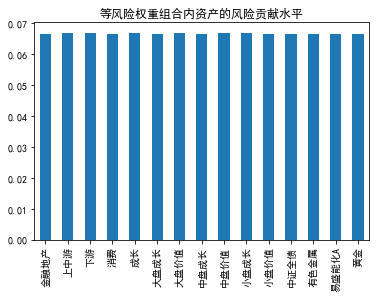

In [121]:
risk_contribution(optim_w_rp2, cov2).plot.bar(title="等风险权重组合内资产的风险贡献水平");

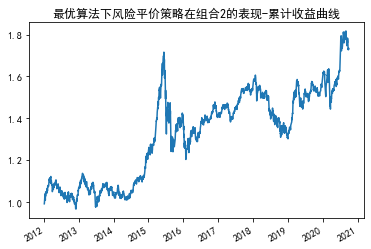

In [122]:
port_RP2 = np.sum(optim_w_rp2* rets_p2,axis = 1)
cumrets_RP2 = (1+port_RP2).cumprod()
cumrets_RP2.plot(title = "最优算法下风险平价策略在组合2的表现-累计收益曲线")

In [123]:
de.Summary_Stats(pd.DataFrame(port_RP2))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.066698,0.137986,-0.602866,6.793527,0.014822,0.021957,0.258233,-0.29903


5. 等预期损失贡献组合

In [64]:
optim_w_ccvar2 = obj_cvar_equal(rets_p2,5)
optim_w_ccvar2

array([0.04743361, 0.03949528, 0.03891845, 0.0454835 , 0.03869237,
       0.04455321, 0.0530179 , 0.04066672, 0.04061954, 0.03999552,
       0.03908403, 0.06322897, 0.11841045, 0.12525699, 0.22514347])

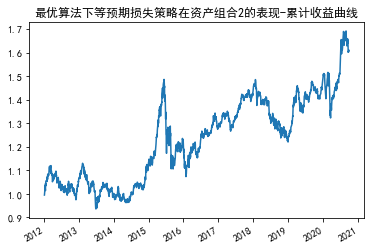

In [65]:
port_ccvar2 = np.sum(optim_w_ccvar2 * rets_p2,axis = 1)
cumrets_ccvar2 = (1+port_ccvar2).cumprod()
cumrets_ccvar2.plot(title = "最优算法下等预期损失策略在资产组合2的表现-累计收益曲线")

In [66]:
de.Summary_Stats(pd.DataFrame(port_ccvar2))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.057409,0.130803,-0.47273,6.256175,0.01388,0.020383,0.203459,-0.278061


6. 等权重组合

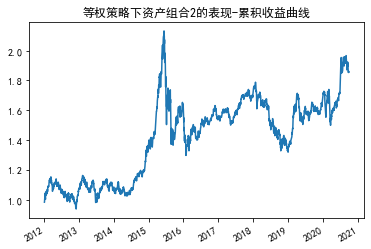

In [67]:
weights_eq2 = [1/15]*15
eqport_rets2= np.sum(weights_eq2 * rets_p2,axis = 1)
cumrets_eq2 = (1+eqport_rets2).cumprod()
cumrets_eq2.plot(title="等权策略下资产组合2的表现-累积收益曲线")

In [68]:
de.Summary_Stats(pd.DataFrame(eqport_rets2))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.075484,0.182022,-0.696941,7.279904,0.019755,0.029405,0.242623,-0.391084


## 生成图例

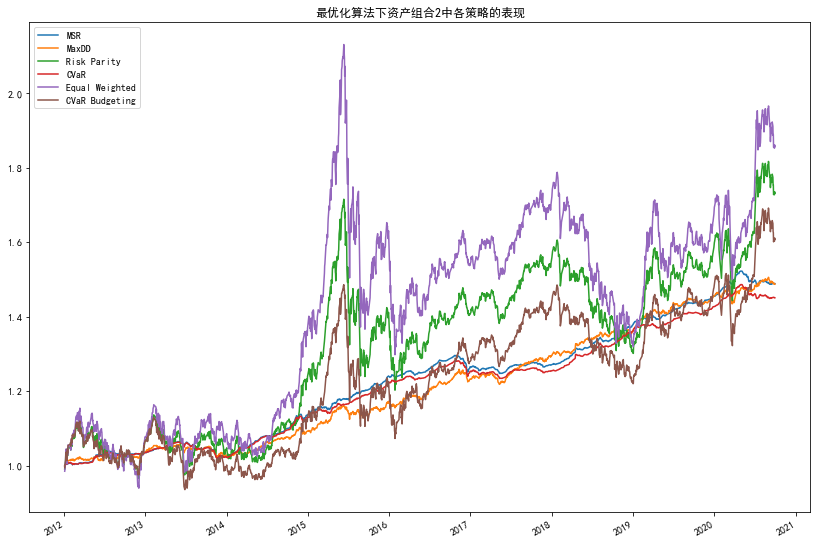

In [69]:
cumrets_msr2.plot(figsize=(14,10),label = "MSR",title = "最优化算法下资产组合2中各策略的表现" , legend = True)
cumrets_maxdd2.plot(figsize=(14,10),label = "MaxDD", legend = True)
cumrets_RP2.plot(figsize=(14,10),label = "Risk Parity", legend = True)
cumrets_cvar2.plot(figsize=(14,10),label = "CVaR" , legend = True)
cumrets_eq2.plot(figsize=(14,10),label = "Equal Weighted", legend = True)
cumrets_ccvar2.plot(figsize=(14,10),label = "CVaR Budgeting", legend = True)

In [70]:
btr_scipy2 = pd.DataFrame({"SR Portfolio": port_msr2, "MaxDD Portfolio": port_mdd2, "RP Portfolio": port_RP2, "CVaR Portfolio": port_cvar2, "CVaR Budgeting": port_ccvar2,"EQ Portfolio": eqport_rets2})
de.Summary_Stats(btr_scipy2)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
SR Portfolio,0.047908,0.013422,-0.200703,12.049224,0.001101,0.001829,1.295525,-0.042126
MaxDD Portfolio,0.047815,0.027270,-0.072649,4.770027,0.002622,0.003730,0.634326,-0.032588
RP Portfolio,0.066698,0.137986,-0.602866,6.793527,0.014822,0.021957,0.258233,-0.299030
CVaR Portfolio,0.044721,0.013008,-0.190178,12.971645,0.001056,0.001802,1.098805,-0.042100
CVaR Budgeting,0.057409,0.130803,-0.472730,6.256175,0.013880,0.020383,0.203459,-0.278061
EQ Portfolio,0.075484,0.182022,-0.696941,7.279904,0.019755,0.029405,0.242623,-0.391084


---

<font color = 'red'> **对第三个资产组合进行配置**

1. 最大化夏普比组合

In [71]:
w_msr3 = obj_msr(rets_p3)
optim_msr3 = w_msr3 / sum(w_msr3)
optim_msr3

array([9.96209219e-01, 3.79078082e-03, 2.49401237e-12, 2.56197886e-12])

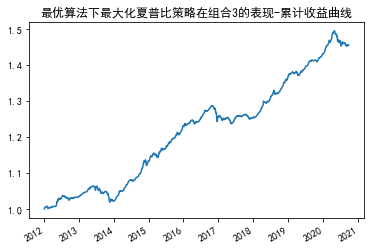

In [72]:
port_msr3 = np.sum(optim_msr3 * rets_p3,axis = 1)
cumrets_msr3 = (1+port_msr3).cumprod()
cumrets_msr3.plot(title = "最优算法下最大化夏普比策略在组合3的表现-累计收益曲线")

In [73]:
de.Summary_Stats(pd.DataFrame(port_msr3))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.045123,0.013176,-0.047381,13.606578,0.001026,0.001816,1.114413,-0.042739


2. 最小化最大回撤策略

In [74]:
optim_w_mdd3 = obj_mdd(rets_p3)/sum(obj_mdd(rets_p3))
optim_w_mdd3

array([0.8596661 , 0.        , 0.12145145, 0.01888246])

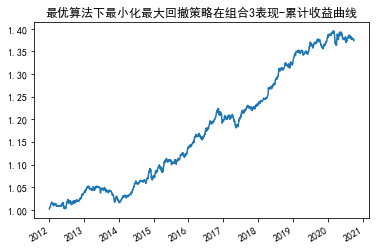

In [75]:
port_mdd3 = np.sum(optim_w_mdd3 * rets_p3,axis = 1)
cumrets_maxdd3 = (1+port_mdd3).cumprod()
cumrets_maxdd3.plot(title = "最优算法下最小化最大回撤策略在组合3表现-累计收益曲线")

In [76]:
de.Summary_Stats(pd.DataFrame(port_mdd3))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.038032,0.022419,-0.019929,4.633959,0.002143,0.003001,0.347864,-0.034898


3. 最小化预期损失策略

In [77]:
optim_w_mincvar3 = obj_cvar(rets = rets_p3,level = 5)/sum(obj_cvar(rets_p3,5))
optim_w_mincvar3

array([0.98141897, 0.01082844, 0.0077526 , 0.        ])

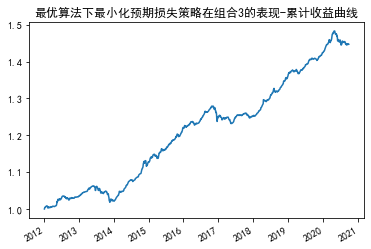

In [78]:
port_cvar3 = np.sum(optim_w_mincvar3 * rets_p3,axis = 1)
cumrets_cvar3 = (1+port_cvar3).cumprod()
cumrets_cvar3.plot(title = "最优算法下最小化预期损失策略在组合3的表现-累计收益曲线")

In [79]:
de.Summary_Stats(pd.DataFrame(port_cvar3))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.0444,0.013038,-0.164713,12.854261,0.001056,0.001811,1.072443,-0.042007


4. 风险平价策略

In [124]:
cov3 = rets_p3.cov()*250
optim_w_rp3 = equal_risk_contributions(cov3)
optim_w_rp3

array([0.82749626, 0.05419777, 0.05309   , 0.06521597])

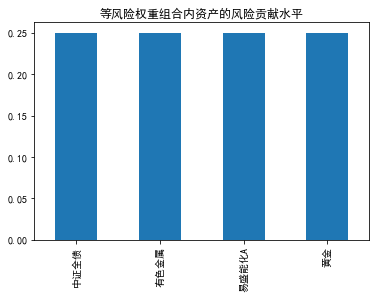

In [125]:
risk_contribution(optim_w_rp3, cov3).plot.bar(title="等风险权重组合内资产的风险贡献水平");

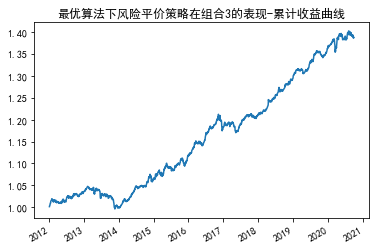

In [126]:
port_RP3 = np.sum(optim_w_rp3* rets_p3,axis = 1)
cumrets_RP3 = (1+port_RP3).cumprod()
cumrets_RP3.plot(title = "最优算法下风险平价策略在组合3的表现-累计收益曲线")

In [127]:
de.Summary_Stats(pd.DataFrame(port_RP3))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.039238,0.02119,-0.101975,5.497214,0.00202,0.002886,0.423333,-0.049218


5.等预期损失均衡策略

In [84]:
optim_w_ccvar3 = obj_cvar_equal(rets_p3,5)
optim_w_ccvar3

array([0.81287068, 0.05871962, 0.0577468 , 0.0706629 ])

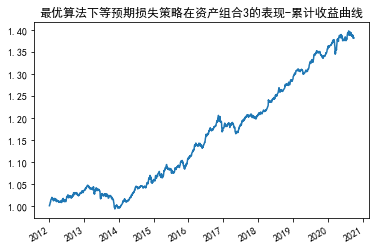

In [85]:
port_ccvar3 = np.sum(optim_w_ccvar3 * rets_p3,axis = 1)
cumrets_ccvar3 = (1+port_ccvar3).cumprod()
cumrets_ccvar3.plot(title = "最优算法下等预期损失策略在资产组合3的表现-累计收益曲线")

In [87]:
de.Summary_Stats(pd.DataFrame(port_ccvar3))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.038706,0.022467,-0.093688,5.389294,0.002153,0.003057,0.376273,-0.051406


6. 等权重策略

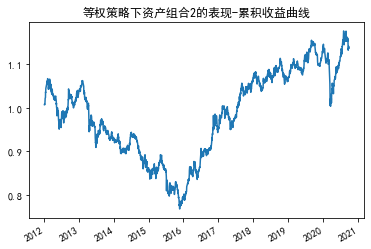

In [86]:
weights_eq3 = [1/4]*4
eqport_rets3= np.sum(weights_eq3 * rets_p3,axis = 1)
cumrets_eq3 = (1+eqport_rets3).cumprod()
cumrets_eq3.plot(title="等权策略下资产组合2的表现-累积收益曲线")

In [88]:
de.Summary_Stats(pd.DataFrame(eqport_rets3))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
0,0.01529,0.081933,-0.108366,5.577941,0.008336,0.01177,-0.174331,-0.281269


## 生成图例

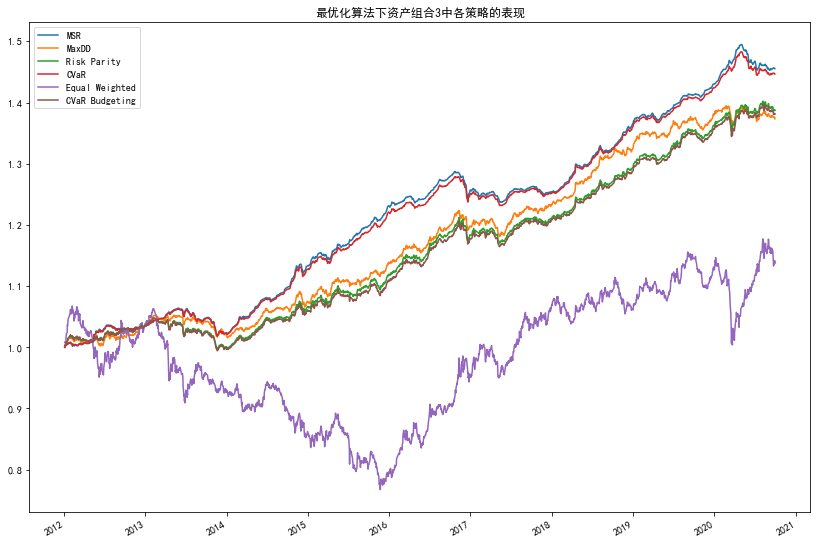

In [89]:
cumrets_msr3.plot(figsize=(14,10),label = "MSR",title = "最优化算法下资产组合3中各策略的表现" , legend = True)
cumrets_maxdd3.plot(figsize=(14,10),label = "MaxDD", legend = True)
cumrets_RP3.plot(figsize=(14,10),label = "Risk Parity", legend = True)
cumrets_cvar3.plot(figsize=(14,10),label = "CVaR" , legend = True)
cumrets_eq3.plot(figsize=(14,10),label = "Equal Weighted", legend = True)
cumrets_ccvar3.plot(figsize=(14,10),label = "CVaR Budgeting", legend = True)

In [90]:
btr_scipy3 = pd.DataFrame({"SR Portfolio": port_msr3, "MaxDD Portfolio": port_mdd3, "RP Portfolio": port_RP3, "CVaR Portfolio": port_cvar3, "CVaR Budgeting": port_ccvar3,"EQ Portfolio": eqport_rets3})
de.Summary_Stats(btr_scipy3)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
SR Portfolio,0.045123,0.013176,-0.047381,13.606578,0.001026,0.001816,1.114413,-0.042739
MaxDD Portfolio,0.038032,0.022419,-0.019929,4.633959,0.002143,0.003001,0.347864,-0.034898
RP Portfolio,0.039238,0.021190,-0.101975,5.497214,0.002020,0.002886,0.423333,-0.049218
CVaR Portfolio,0.044400,0.013038,-0.164713,12.854261,0.001056,0.001811,1.072443,-0.042007
CVaR Budgeting,0.038706,0.022467,-0.093688,5.389294,0.002153,0.003057,0.376273,-0.051406
EQ Portfolio,0.015290,0.081933,-0.108366,5.577941,0.008336,0.011770,-0.174331,-0.281269


---

## <font color = 'midnightblue'> **滚动计算-窗口期选择1年** </font>

通过滚动计算分别对6种不同的投资策略在三个资产组合中的表现进行回测，并着重研究了风险平价策略在滚动计算的表现以及相关时点的持仓情况

In [128]:
def weight_ew(rets):
    """
    return the weights of the EQ portfolio
    """
    n = len(rets.columns)
    return pd.Series(1/n, index = rets.columns)

def backtest_rolling(rets, obj_fun, estimation_window=250):
    """
    Backtests a given optimization scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    obj_fun: objective function given above: MaxSR,MinMaxDD,MinCVaR,RiskParity,CVaR_Budgeting,EQ
    """
    n_periods = rets.shape[0]
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    # windows is a list of tuples which gives us the (integer) location of the start and stop (non inclusive)
    # for each estimation window
    weights = [obj_fun(rets.iloc[win[0]:win[1]]) for win in windows]
    # List -> DataFrame
    weights = pd.DataFrame(weights, index=rets.iloc[estimation_window-1:].index, columns=rets.columns)
    # return weights
    returns = (weights * rets).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns.dropna()

### <font color = 'red'>**对第一个资产组合中的不同策略进行滚动测试**

1. 对最大夏普比率组合进行滚动计算

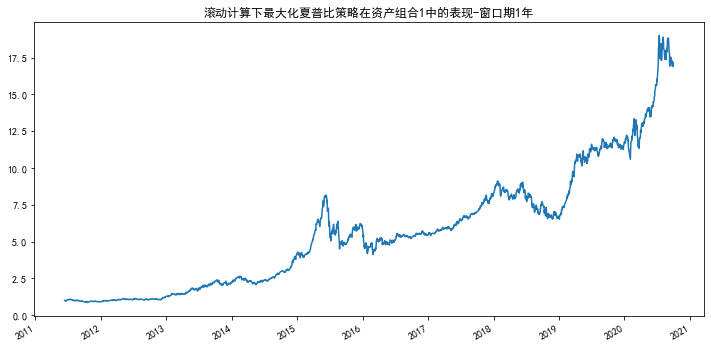

In [129]:
msr_btr1 = backtest_rolling(rets = rets_p1,obj_fun = obj_msr)
msr_cumr_bt1 = (1+msr_btr1).cumprod()
msr_cumr_bt1.plot(figsize=(12,6), title="滚动计算下最大化夏普比策略在资产组合1中的表现-窗口期1年")

2. 对最小化最大回撤策略进行滚动计算

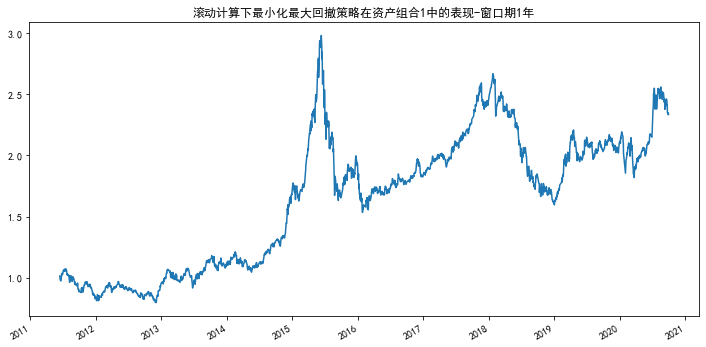

In [130]:
mdd_btr1 = backtest_rolling(rets = rets_p1,obj_fun = obj_mdd)
mdd_cumr_bt1 = (1+mdd_btr1).cumprod()
mdd_cumr_bt1.plot(figsize=(12,6), title="滚动计算下最小化最大回撤策略在资产组合1中的表现-窗口期1年")

3. 对最小化预期损失策略进行滚动计算

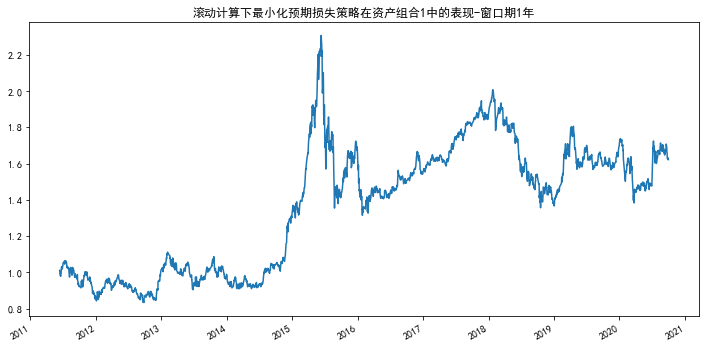

In [131]:
cvar_btr1 = backtest_rolling(rets = rets_p1,obj_fun = obj_cvar)
cvar_cumr_bt1 = (1+cvar_btr1).cumprod()
cvar_cumr_bt1.plot(figsize=(12,6), title="滚动计算下最小化预期损失策略在资产组合1中的表现-窗口期1年")

4. 对风险平价策略进行滚动计算

In [144]:
def erc(rets = rets_p1):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    covmatrix = rets.corr()
    n = covmatrix.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n
    target_risk=np.repeat(1/n,n)
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    
    def erc_risk(weights,cov,target_risk):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        cov = covmatrix
        total_portfolio_var = np.sqrt(weights.T @ cov @ weights)
        # Marginal contribution of each constituent
        marginal_contrib = cov @ weights
        risk_contrib = np.multiply(marginal_contrib,weights.T)/total_portfolio_var
        
        return ((risk_contrib-target_risk)**2).sum()
    
    weights = minimize(erc_risk, init_guess,
                       args = (covmatrix, target_risk), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

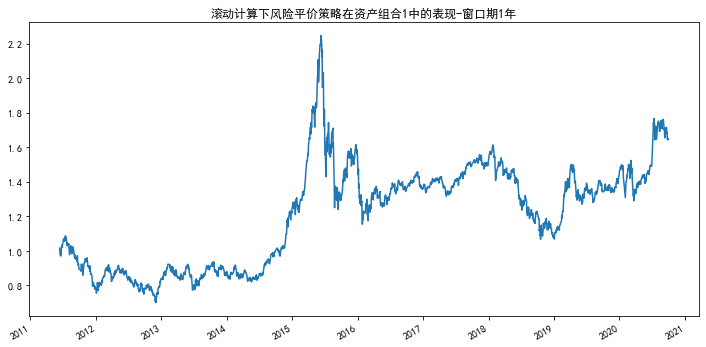

In [145]:
RP_btr1 = backtest_rolling(rets = rets_p1,obj_fun =erc)
RP_cumr_bt1 = (1+RP_btr1).cumprod()
RP_cumr_bt1.plot(figsize=(12,6), title="滚动计算下风险平价策略在资产组合1中的表现-窗口期1年")

In [146]:
estimation_window = 250
n_periods1 = rets_p1.shape[0]
windows = [(start, start+estimation_window) for start in range(n_periods1-estimation_window+1)]
rp_weights1 = [erc(rets_p1.iloc[win[0]:win[1]]) for win in windows]
rp_weights1 = pd.DataFrame(rp_weights1, index=rets_p1.iloc[estimation_window-1:].index, columns=rets_p1.columns)

In [136]:
def mean_weights(weights):
    n = weights.shape[0]
    return (np.sum(weights)) / n

In [147]:
rp_weights_m1 = rp_weights1.resample('M').apply(mean_weights).to_period('M')
rp_weights_m1

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


,金融地产,上中游,下游,消费,成长,大盘成长,大盘价值,中盘成长,中盘价值,小盘成长,小盘价值
2011-06,0.099943,0.094347,0.088972,0.096033,0.098993,0.087238,0.094769,0.084866,0.083678,0.085181,0.085981
2011-07,0.099941,0.094682,0.089166,0.096764,0.098027,0.087103,0.094647,0.084825,0.083628,0.085169,0.086047
2011-08,0.100129,0.095218,0.088903,0.096970,0.097946,0.087049,0.094839,0.084664,0.083412,0.084987,0.085882
2011-09,0.099520,0.095353,0.088870,0.097540,0.098133,0.087083,0.094684,0.084643,0.083404,0.084965,0.085806
2011-10,0.098950,0.094863,0.089434,0.097121,0.097113,0.087332,0.094387,0.084986,0.084119,0.085467,0.086229
...,...,...,...,...,...,...,...,...,...,...,...
2020-05,0.092141,0.097639,0.087501,0.100724,0.091055,0.087687,0.093602,0.087854,0.087080,0.088565,0.086152
2020-06,0.092174,0.097709,0.087286,0.101406,0.091407,0.087500,0.093495,0.087722,0.086964,0.088467,0.085869
2020-07,0.093386,0.095615,0.086957,0.101646,0.092547,0.087641,0.094135,0.087861,0.086616,0.088212,0.085383
2020-08,0.093975,0.095301,0.086840,0.101672,0.092650,0.087835,0.094655,0.087600,0.086540,0.087783,0.085151


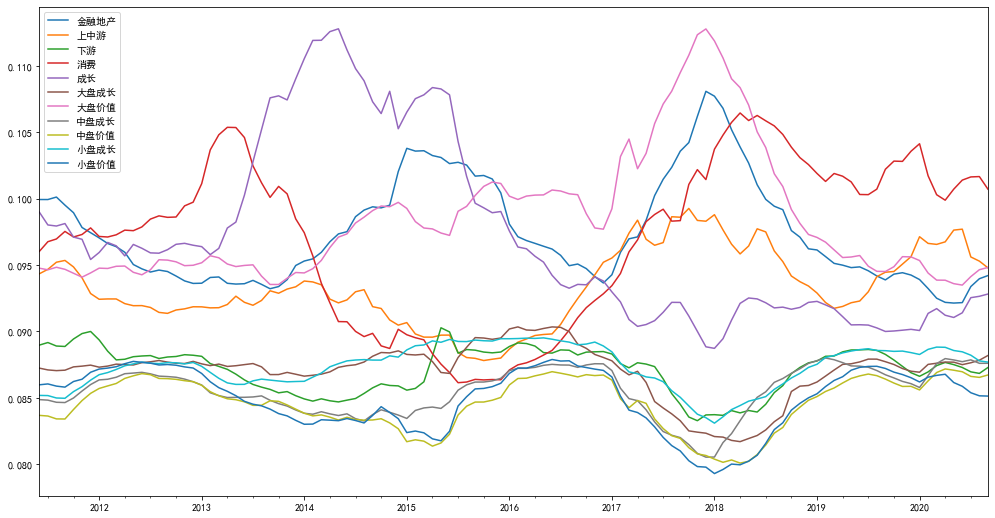

In [149]:
rp_weights_m1.plot(figsize = (17,9))

- 可以看出，资产权重调整幅度大的资产有消费、成长、金融地产、小盘价值、上中游等，这些资产的波动率相对较大，因此风险平价策略在配置这些资产权重时调节频率更大幅度更大。

5. 对等预期损失策略进行滚动计算

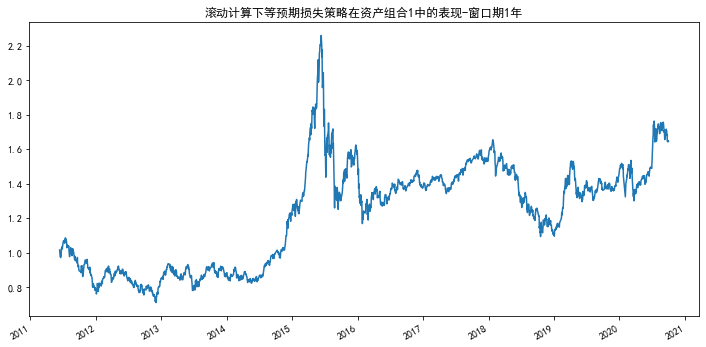

In [140]:
ccvar_btr1 = backtest_rolling(rets = rets_p1,obj_fun = obj_cvar_equal)
ccvar_cumr_bt1 = (1+ccvar_btr1).cumprod()
ccvar_cumr_bt1.plot(figsize=(12,6), title="滚动计算下等预期损失策略在资产组合1中的表现-窗口期1年")

## 生成图例

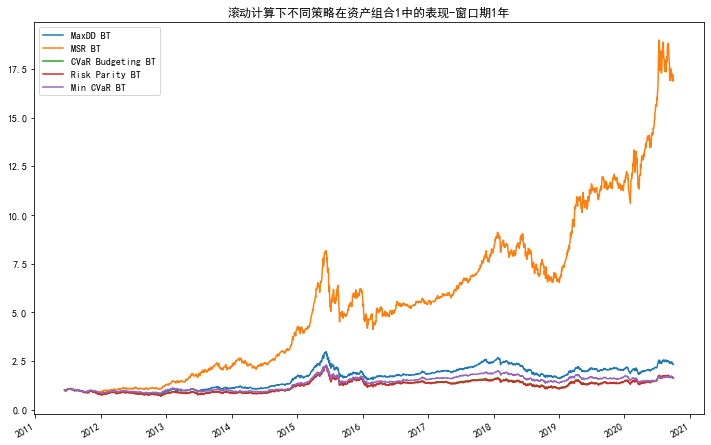

In [150]:
mdd_cumr_bt1.plot(figsize=(12,8), title="滚动计算下不同策略在资产组合1中的表现-窗口期1年",label = "MaxDD BT", legend = True)
msr_cumr_bt1.plot(figsize=(12,8),label = "MSR BT",legend= True)
ccvar_cumr_bt1.plot(figsize=(12,8),label = "CVaR Budgeting BT", legend = True)
RP_cumr_bt1.plot(figsize=(12,8),label = "Risk Parity BT",legend = True)
cvar_cumr_bt1.plot(figsize=(12,8),label = "Min CVaR BT",legend = True)

In [151]:
btr_rolling1 = pd.DataFrame({"最大夏普策略": msr_btr1, "最小化最大回撤策略": mdd_btr1, "风险平价策略": RP_btr1, "最小化预期损失策略": cvar_btr1, "预期损失均衡策略": ccvar_btr1})
de.Summary_Stats(btr_rolling1)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
最大夏普策略,0.368458,0.275407,-0.541406,6.053269,0.028747,0.041693,1.193283,-0.495011
最小化最大回撤策略,0.098055,0.223994,-0.554006,7.103410,0.023798,0.034602,0.294999,-0.485793
风险平价策略,0.056642,0.236915,-0.701308,7.324191,0.025848,0.038275,0.109177,-0.525479
最小化预期损失策略,0.054753,0.209353,-0.537490,8.145202,0.022049,0.032716,0.114794,-0.429662
预期损失均衡策略,0.056537,0.234372,-0.696963,7.421076,0.025524,0.037798,0.109926,-0.516831


### <font color = 'red'>**对第二个资产组合中的不同策略进行滚动测试**

1. 对最大夏普比组合进行滚动计算

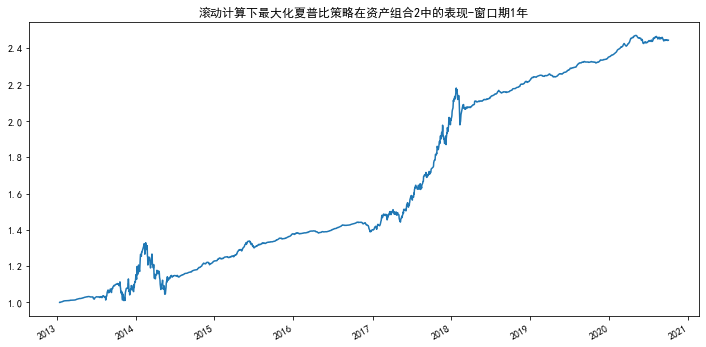

In [152]:
msr_btr2 = backtest_rolling(rets = rets_p2,obj_fun = obj_msr)
msr_cumr_bt2 = (1+msr_btr2).cumprod()
msr_cumr_bt2.plot(figsize=(12,6), title="滚动计算下最大化夏普比策略在资产组合2中的表现-窗口期1年")

2. 对最小化最大回撤策略进行滚动计算

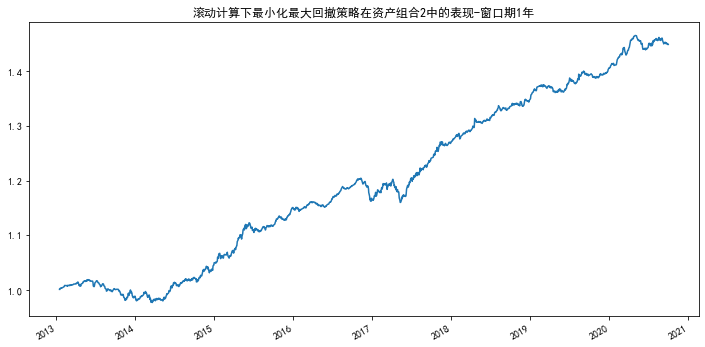

In [153]:
mdd_btr2 = backtest_rolling(rets = rets_p2,obj_fun = obj_mdd)
mdd_cumr_bt2 = (1+mdd_btr2).cumprod()
mdd_cumr_bt2.plot(figsize=(12,6), title="滚动计算下最小化最大回撤策略在资产组合2中的表现-窗口期1年")

3. 对最小化预期损失策略进行滚动计算

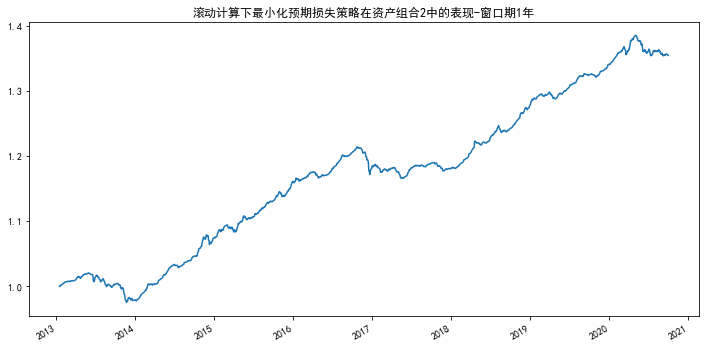

In [155]:
cvar_btr2 = backtest_rolling(rets = rets_p2,obj_fun = obj_cvar)
cvar_cumr_bt2 = (1+cvar_btr2).cumprod()
cvar_cumr_bt2.plot(figsize=(12,6), title="滚动计算下最小化预期损失策略在资产组合2中的表现-窗口期1年")

4. 对风险平价策略进行滚动计算

In [156]:
def erc(rets = rets_p2):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    covmatrix = rets.corr()
    n = covmatrix.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n
    target_risk=np.repeat(1/n,n)
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    
    def erc_risk(weights,cov,target_risk):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        cov = covmatrix
        total_portfolio_var = np.sqrt(weights.T @ cov @ weights)
        # Marginal contribution of each constituent
        marginal_contrib = cov @ weights
        risk_contrib = np.multiply(marginal_contrib,weights.T)/total_portfolio_var
        
        return ((risk_contrib-target_risk)**2).sum()
    
    weights = minimize(erc_risk, init_guess,
                       args = (covmatrix, target_risk), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

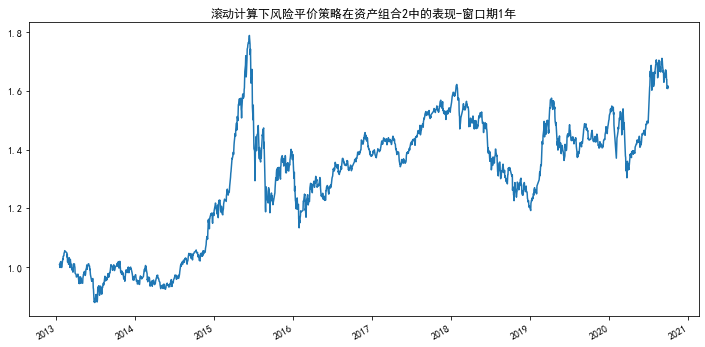

In [157]:
RP_btr2 = backtest_rolling(rets = rets_p2,obj_fun =erc)
RP_cumr_bt2 = (1+RP_btr2).cumprod()
RP_cumr_bt2.plot(figsize=(12,6), title="滚动计算下风险平价策略在资产组合2中的表现-窗口期1年")

In [158]:
estimation_window = 250
n_periods2 = rets_p2.shape[0]
windows = [(start, start+estimation_window) for start in range(n_periods2-estimation_window+1)]
rp_weights2 = [erc(rets_p2.iloc[win[0]:win[1]]) for win in windows]
rp_weights2 = pd.DataFrame(rp_weights2, index=rets_p2.iloc[estimation_window-1:].index, columns=rets_p2.columns)

In [159]:
rp_weights_m2 = rp_weights2.resample('M').apply(mean_weights).to_period('M')
rp_weights_m2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


,金融地产,上中游,下游,消费,成长,大盘成长,大盘价值,中盘成长,中盘价值,小盘成长,小盘价值,中证全债,有色金属,易盛能化A,黄金
2013-01,0.063674,0.061301,0.061727,0.070200,0.067358,0.060039,0.064036,0.060292,0.060234,0.061006,0.060944,1.551016e-16,0.086825,0.096358,0.126007
2013-02,0.064198,0.061314,0.061811,0.071807,0.067682,0.060126,0.064564,0.060303,0.060146,0.061212,0.060905,6.578199e-17,0.088653,0.094629,0.122649
2013-03,0.064126,0.061248,0.061623,0.072639,0.068257,0.060161,0.064494,0.060216,0.059952,0.060911,0.060554,7.895880e-17,0.088345,0.092420,0.125054
2013-04,0.064123,0.061131,0.061268,0.072208,0.069324,0.060099,0.064412,0.060108,0.059871,0.060656,0.060434,8.043592e-17,0.089144,0.091102,0.126120
2013-05,0.064541,0.061525,0.061131,0.072124,0.070114,0.060384,0.064699,0.060363,0.060072,0.060735,0.060427,1.008140e-16,0.091440,0.090202,0.122245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05,0.060970,0.062287,0.058941,0.065967,0.061063,0.058564,0.061448,0.059052,0.058649,0.059596,0.058485,7.485136e-17,0.074715,0.085658,0.174603
2020-06,0.061489,0.062795,0.059345,0.066919,0.061846,0.058933,0.061914,0.059502,0.059062,0.060151,0.058847,1.627703e-16,0.074478,0.085423,0.169297
2020-07,0.063167,0.062234,0.059518,0.067203,0.062703,0.059299,0.063150,0.059779,0.059344,0.060222,0.058945,4.356165e-17,0.073165,0.085397,0.165873
2020-08,0.064352,0.062669,0.059812,0.067497,0.063218,0.059644,0.064213,0.059970,0.059708,0.060370,0.059206,6.556525e-17,0.073943,0.087241,0.158158


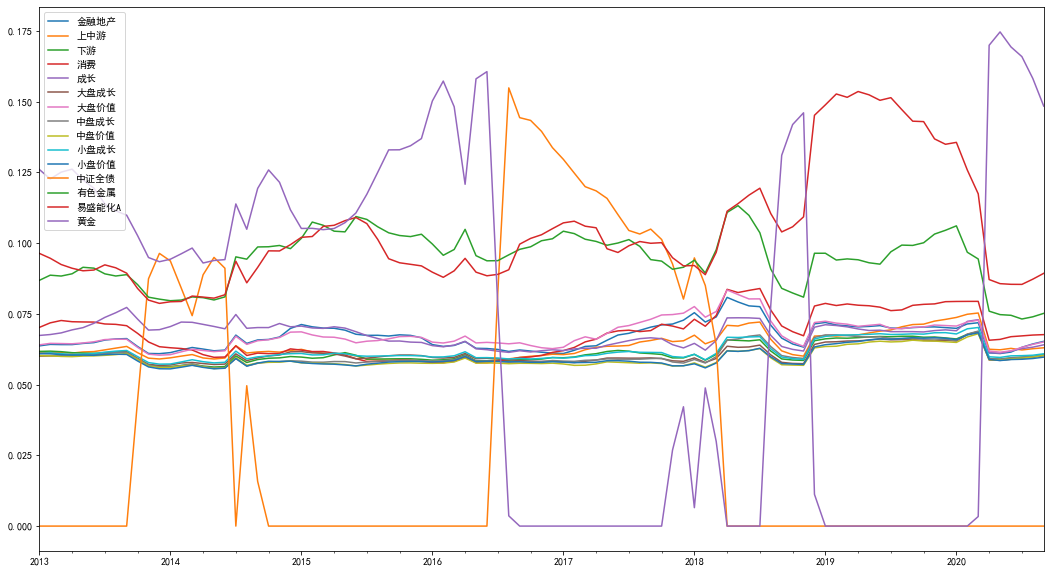

In [160]:
rp_weights_m2.plot(figsize = (18,10))

由于组合二中包含了债券和大宗商品这些波动率较低的资产，因此在风险平价策略下，个别高波动率资产的配置权重的变化幅度会被放大。

5. 对等预期损失策略进行滚动计算

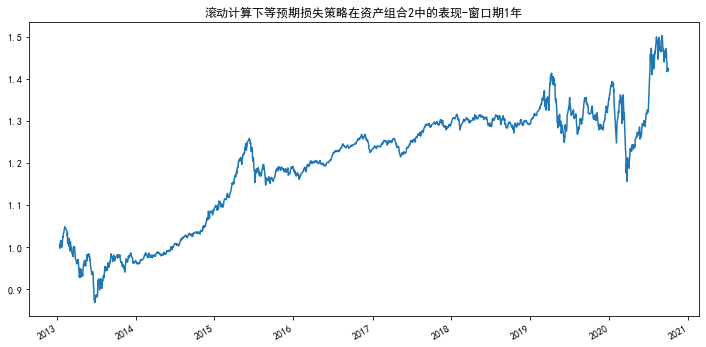

In [161]:
ccvar_btr2 = backtest_rolling(rets = rets_p2,obj_fun = obj_cvar_equal)
ccvar_cumr_bt2 = (1+ccvar_btr2).cumprod()
ccvar_cumr_bt2.plot(figsize=(12,6), title="滚动计算下等预期损失策略在资产组合2中的表现-窗口期1年")

## 生成图例

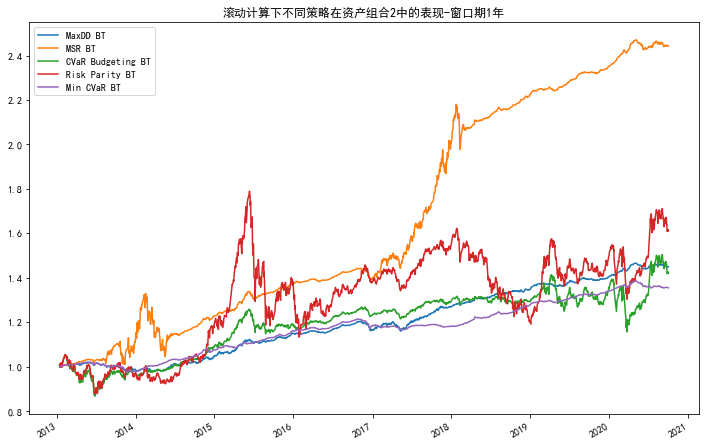

In [162]:
mdd_cumr_bt2.plot(figsize=(12,8), title="滚动计算下不同策略在资产组合2中的表现-窗口期1年",label = "MaxDD BT", legend = True)
msr_cumr_bt2.plot(figsize=(12,8),label = "MSR BT",legend= True)
ccvar_cumr_bt2.plot(figsize=(12,8),label = "CVaR Budgeting BT", legend = True)
RP_cumr_bt2.plot(figsize=(12,8),label = "Risk Parity BT",legend = True)
cvar_cumr_bt2.plot(figsize=(12,8),label = "Min CVaR BT",legend = True)

In [163]:
btr_rolling2 = pd.DataFrame({"最大夏普策略": msr_btr2, "最小化最大回撤策略": mdd_btr2, "风险平价策略": RP_btr2, "最小化预期损失策略": cvar_btr2, "预期损失均衡策略": ccvar_btr2})
de.Summary_Stats(btr_rolling2)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
最大夏普策略,0.126428,0.091654,-0.907842,21.579414,0.008272,0.014849,1.021566,-0.213598
最小化最大回撤策略,0.050663,0.024034,0.057167,5.393833,0.002203,0.003253,0.834802,-0.041190
风险平价策略,0.065752,0.177955,-0.777539,7.528520,0.019520,0.029304,0.195063,-0.367116
最小化预期损失策略,0.041281,0.013053,-0.454130,12.735968,0.001137,0.001881,0.839214,-0.044432
预期损失均衡策略,0.048034,0.095663,-1.490786,20.929267,0.009865,0.015395,0.183040,-0.182310


### <font color = 'red'>**对第三个资产组合中的不同策略进行滚动测试**

1. 对最大夏普比率组合进行滚动计算

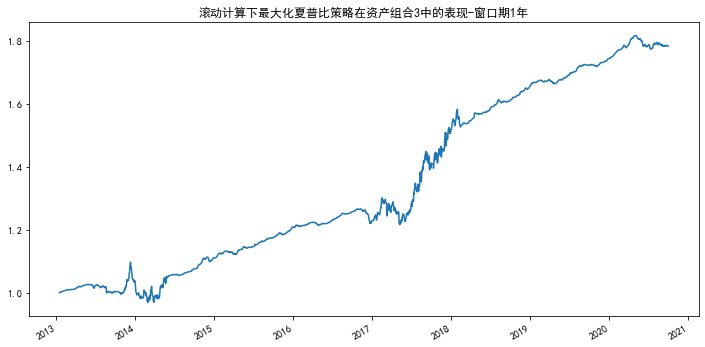

In [164]:
msr_btr3 = backtest_rolling(rets = rets_p3,obj_fun = obj_msr)
msr_cumr_bt3 = (1+msr_btr3).cumprod()
msr_cumr_bt3.plot(figsize=(12,6), title="滚动计算下最大化夏普比策略在资产组合3中的表现-窗口期1年")

2. 对最小化最大回撤策略进行滚动计算

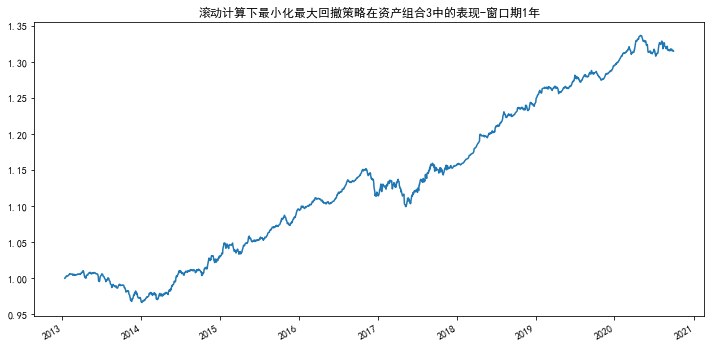

In [165]:
mdd_btr3= backtest_rolling(rets = rets_p3,obj_fun = obj_mdd)
mdd_cumr_bt3 = (1+mdd_btr3).cumprod()
mdd_cumr_bt3.plot(figsize=(12,6), title="滚动计算下最小化最大回撤策略在资产组合3中的表现-窗口期1年")

3. 对最小化预期损失策略进行滚动计算

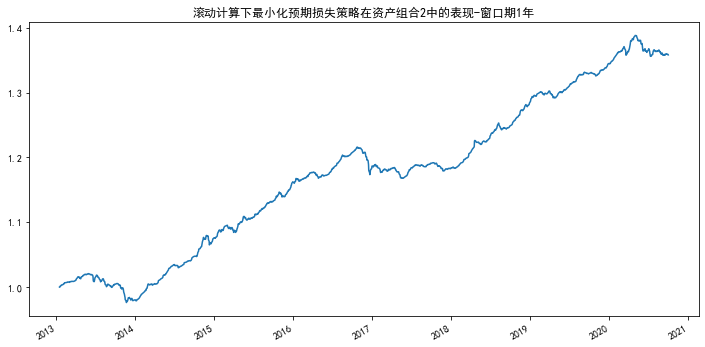

In [166]:
cvar_btr3 = backtest_rolling(rets = rets_p3,obj_fun = obj_cvar)
cvar_cumr_bt3 = (1+cvar_btr3).cumprod()
cvar_cumr_bt3.plot(figsize=(12,6), title="滚动计算下最小化预期损失策略在资产组合2中的表现-窗口期1年")

4. 对风险平价策略进行滚动计算

In [176]:
def erc(rets = rets_p3):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    covmatrix = rets.corr()
    n = covmatrix.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n
    target_risk=np.repeat(1/n,n)
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    
    def erc_risk(weights,cov,target_risk):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        cov = covmatrix
        total_portfolio_var = np.sqrt(weights.T @ cov @ weights)
        # Marginal contribution of each constituent
        marginal_contrib = cov @ weights
        risk_contrib = np.multiply(marginal_contrib,weights.T)/total_portfolio_var
        
        return ((risk_contrib-target_risk)**2).sum()
    
    weights = minimize(erc_risk, init_guess,
                       args = (covmatrix, target_risk), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

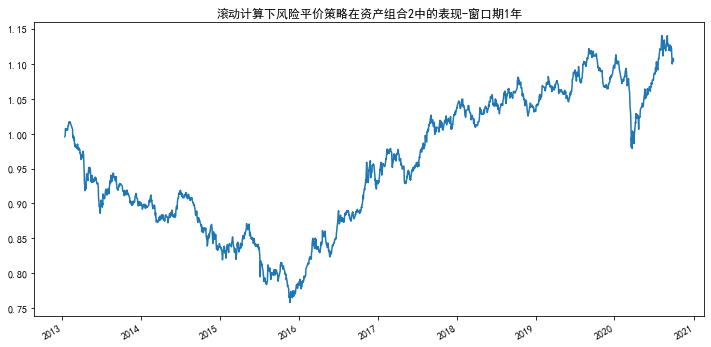

In [177]:
RP_btr3 = backtest_rolling(rets = rets_p3,obj_fun =erc)
RP_cumr_bt3 = (1+RP_btr3).cumprod()
RP_cumr_bt3.plot(figsize=(12,6), title="滚动计算下风险平价策略在资产组合2中的表现-窗口期1年")

In [178]:
estimation_window = 250
n_periods3 = rets_p3.shape[0]
windows = [(start, start+estimation_window) for start in range(n_periods3-estimation_window+1)]
rp_weights3 = [erc(rets_p3.iloc[win[0]:win[1]]) for win in windows]
rp_weights3 = pd.DataFrame(rp_weights3, index=rets_p3.iloc[estimation_window-1:].index, columns=rets_p3.columns)

In [170]:
rp_weights_m3 = rp_weights3.resample('M').apply(mean_weights).to_period('M')
rp_weights_m3

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


,中证全债,有色金属,易盛能化A,黄金
2013-01,5.788044e-17,0.395986,0.604014,3.655352e-16
2013-02,1.441483e-16,0.369654,0.630346,2.579785e-16
2013-03,9.322823e-17,0.359578,0.640422,6.461248e-17
2013-04,1.876626e-16,0.381762,0.618238,1.252300e-15
2013-05,1.264793e-16,0.434905,0.565095,8.504956e-15
...,...,...,...,...
2020-05,3.102804e-16,0.406599,0.593401,5.121259e-15
2020-06,3.339297e-16,0.412908,0.587092,2.280419e-15
2020-07,2.654405e-16,0.440904,0.559096,7.634247e-16
2020-08,2.247270e-16,0.455136,0.544864,1.223463e-15


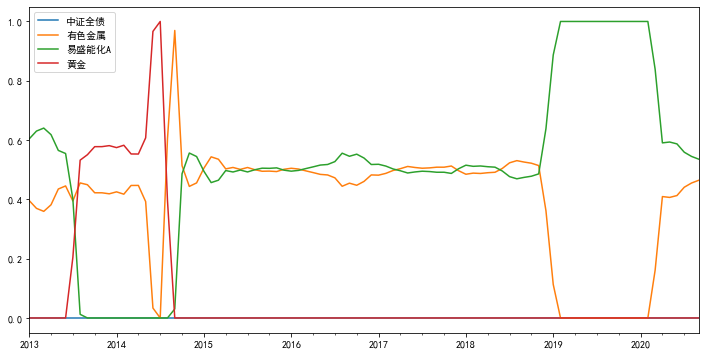

In [179]:
rp_weights_m3.plot(figsize = (12,6))

5. 对等预期损失策略进行滚动计算

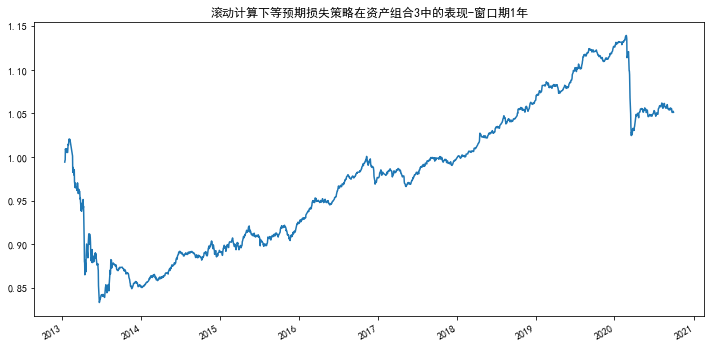

In [180]:
ccvar_btr3 = backtest_rolling(rets = rets_p3,obj_fun = obj_cvar_equal)
ccvar_cumr_bt3 = (1+ccvar_btr3).cumprod()
ccvar_cumr_bt3.plot(figsize=(12,6), title="滚动计算下等预期损失策略在资产组合3中的表现-窗口期1年")

## 生成图例

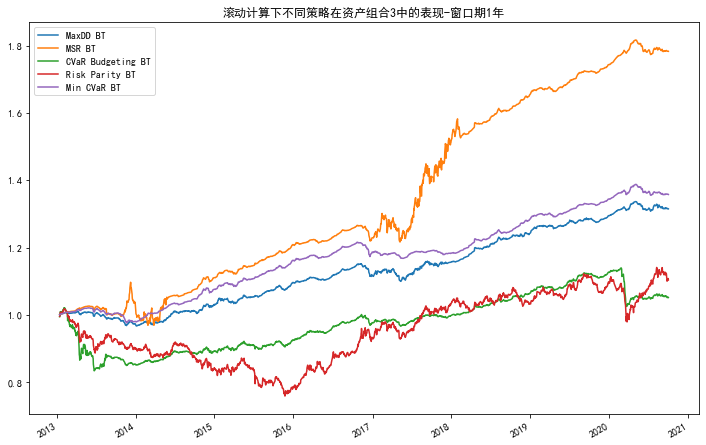

In [181]:
mdd_cumr_bt3.plot(figsize=(12,8), title="滚动计算下不同策略在资产组合3中的表现-窗口期1年",label = "MaxDD BT", legend = True)
msr_cumr_bt3.plot(figsize=(12,8),label = "MSR BT",legend= True)
ccvar_cumr_bt3.plot(figsize=(12,8),label = "CVaR Budgeting BT", legend = True)
RP_cumr_bt3.plot(figsize=(12,8),label = "Risk Parity BT",legend = True)
cvar_cumr_bt3.plot(figsize=(12,8),label = "Min CVaR BT",legend = True)

In [182]:
btr_rolling3 = pd.DataFrame({"最大夏普策略": msr_btr3, "最小化最大回撤策略": mdd_btr3, "风险平价策略": RP_btr3, "最小化预期损失策略": cvar_btr3, "预期损失均衡策略": ccvar_btr3})
de.Summary_Stats(btr_rolling3)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Var(5%),CVaR(5%),Sharp Ratio,Max Drawdown
最大夏普策略,0.080180,0.057578,0.380610,16.528736,0.004275,0.009147,0.846226,-0.116842
最小化最大回撤策略,0.037173,0.021103,-0.101566,6.992065,0.001979,0.003002,0.330032,-0.045425
风险平价策略,0.013302,0.076175,-0.163447,5.633966,0.007823,0.011027,-0.212854,-0.254963
最小化预期损失策略,0.041600,0.013142,-0.455074,12.448049,0.001149,0.001903,0.857065,-0.043696
预期损失均衡策略,0.006675,0.045033,-3.185634,49.440171,0.004020,0.007394,-0.502942,-0.183771
